In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import logging

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для анализа текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

#для парсинга 
import requests 
from bs4 import BeautifulSoup

# для кодирования
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# для шкалирования
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# для удобства просмотра
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 100)

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
!pip install nltk

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

* hotel_address — адрес отеля; 
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# найдём дубликаты в тренировочной выборке
dupl_columns = list(df_train.columns)[1:]
mask = df_train.duplicated(subset=dupl_columns)
duplicates = df_train[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

# очистим выборку от дублей
df_train = df_train.drop_duplicates(subset=dupl_columns)
display(df_train.shape)

Число найденных дубликатов: 307


(386496, 17)

Поищем одинаковые отзывы по тексту с длииной отзывов больше определенного количества слов. Подберем значения отсекающие стандартные типовые отзывы и оставим действительно длинные уникальные двойники. Это явно что-то нечестное.
Фактическое значение слов отзывов на 1-2 слова меньше чем указано в признаке "кол-во слов отзыва".

In [12]:
subset_columns = ['positive_review', 'negative_review']
mask_pos = df_train.duplicated(subset=subset_columns)
duplicates_pos = df_train[
    df_train['review_total_positive_word_counts'] > 9][mask_pos]

mask_neg = df_train.duplicated(subset=subset_columns, keep='last')
duplicates_neg = df_train[
    df_train['review_total_negative_word_counts'] > 8][mask_neg]

print(f'Число найденных позитивных отзывов-двойников: {duplicates_pos.shape[0]}')
print(f'Число найденных негативных отзывов-двойников: {duplicates_neg.shape[0]}')
display(duplicates_pos.head(3))
display(duplicates_neg.head(3))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Число найденных позитивных отзывов-двойников: 30
Число найденных негативных отзывов-двойников: 18


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
45934,2 24 Kensington High St Kensington and Chelsea London W8 4PT United Kingdom,617,1/8/2017,8.800,Royal Garden Hotel,Kuwait,No Negative,0,2213,To be honest everything warm hospitality and the service was amazimg very helpful staff definitely i will be back again,22,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Garden King Room ', ' Stayed 7 nights ']",207 day,51.503,-0.188
66425,Oosterdoksstraat 4 Amsterdam City Center 1011 DK Amsterdam Netherlands,803,5/23/2017,8.400,DoubleTree by Hilton Amsterdam Centraal Station,Crimea,No Negative,0,3911,The hotel the staff and location are fantastic Quiet gracious room I felt very safe at this hotel I am glad that I spent my holiday here,29,49,10.000,"[' Leisure trip ', ' Solo traveler ', ' Queen Guest Room ', ' Stayed 1 night ']",72 days,52.377,4.905
79984,4 rue d Anjou 8th arr 75008 Paris France,97,6/10/2017,8.800,Buddha Bar Hotel Paris,Spain,No Negative,0,538,The room was very spacious and nicely arranged to separate business and leisure Friendly personnel extra nice The whole service The personnel was perfect and the room very comfortable,31,34,10.000,"[' Leisure trip ', ' Solo traveler ', ' Deluxe Room ', ' Stayed 1 night ']",54 days,48.869,2.321


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
11155,Viale Sarca 336 Bicocca Zara 20125 Milan Italy,563,2/13/2017,8.300,Hotel degli Arcimboldi,Oman,Water overflow from bathroom while taking bath Interconnect disconnects again and again Need to go through a procedure to connect it again Nuisance Very small rooms No covered wardrobes for cloth You have to hang it in open air Housekeeping sometimes forgot to put tissues in the bathroom sometimes forget to put soap sometimes drinking water No restaurant in the hotel Have to arrange food from outside restaurant with hotel s help Had to pay Euro 50 for late checkout,81,10842,Friendly and supportive staff New construction clean rooms Heated bathrooms No noise 3 lifts Location near to metro station and the destination where I wanted to visit everyday Good seating capacity for the restaurant during breakfast Good variety in the breakfast Ability to order halal food through the hotel staff,51,8,7.900,"[' Business trip ', ' Solo traveler ', ' Double Room ', ' Stayed 1 night ']",171 day,45.526,9.215
25065,8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,602,9/27/2016,8.500,Club Quarters Hotel Trafalgar Square,Ukraine,Breakfast was very poor and expensive so we decide to take breakfast outside Hotel is overpriced even with 50 discount just good location We don t feel service like in 4 stars AA hotel No underground car park but it s ok for center of London,48,2494,Just good location nothing more,7,121,6.300,"[' Leisure trip ', ' Group ', ' Standard Queen Room ', ' Stayed 2 nights ']",310 day,51.507,-0.126
25091,58 Shepherds Bush Green Hammersmith and Fulham London W12 8QE United Kingdom,690,11/21/2016,8.600,Dorsett Shepherds Bush,Russia,It was a strange chemical cleanser s smell in our room And also it wasn t possible to open windows We also got a room for disabled people didn t expect it,34,2890,Good lobby interior,4,66,7.500,"[' Leisure trip ', ' Couple ', ' Dorsett Double Room ', ' Stayed 2 nights ']",255 day,51.504,-0.224


In [13]:
# Удалим отзывы двойники 
drop_index = list(duplicates_pos.index) + list(duplicates_neg.index)
df_train.drop(index=drop_index, inplace=True)
df_train.shape[0]

386449

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

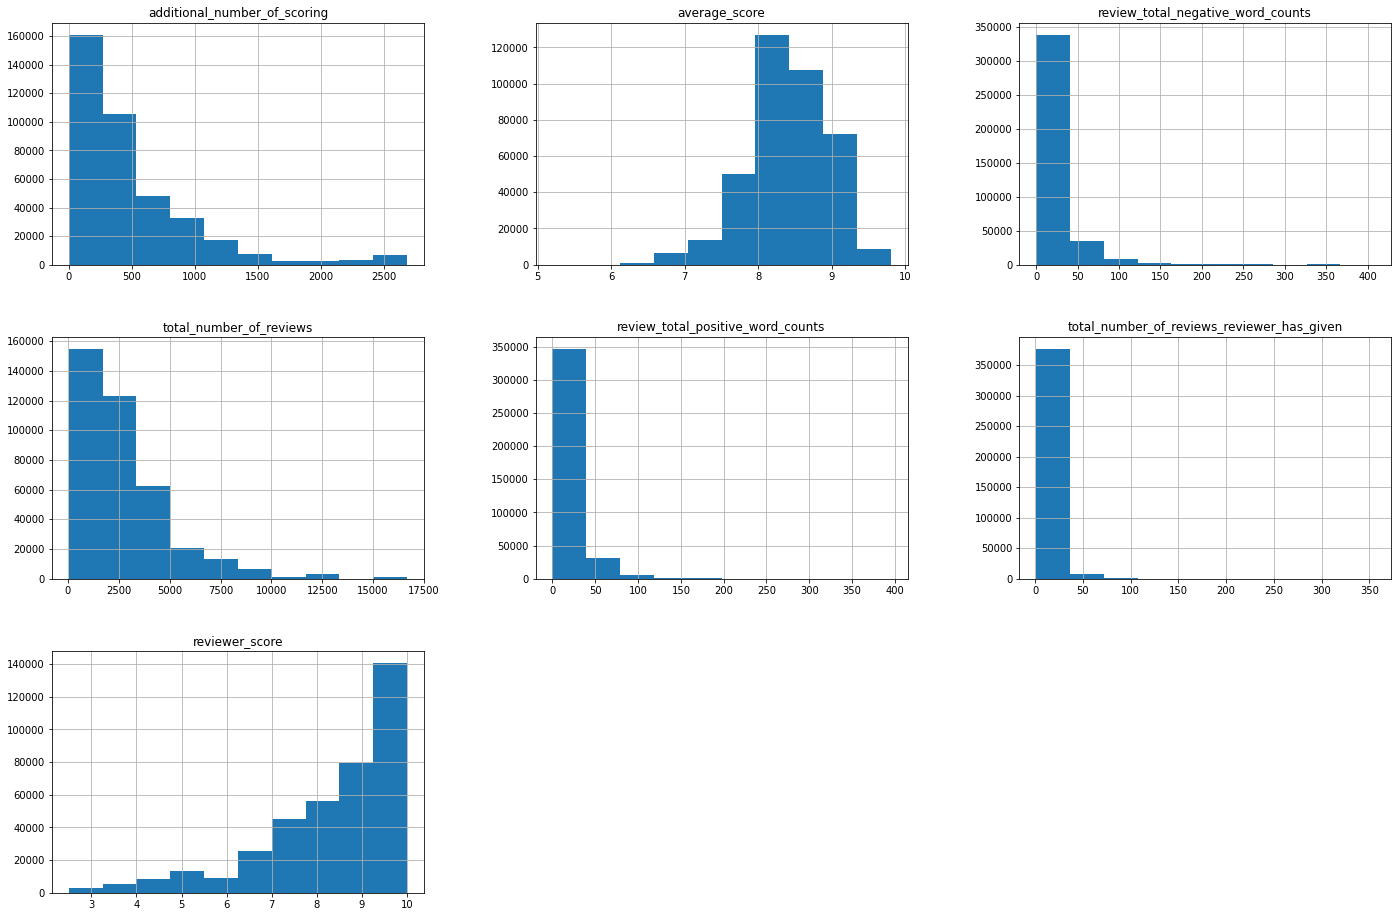

In [14]:
# Построим гистограммы для числовых признаков, исключив неинформативные признаки
df_train.drop(['lat', 'lng'], axis=1).hist(figsize=(24,16))

Выводы: 
1. Признаки указывающие на кол-во слов в отзыве, сильно смещены к 0, так как 0 слов соответствует видимо автоматически проставляемому 'No pistive/No negative'.  Для Наглядности построим более детально гистограммы для этих признаков.
2. Сумарное количество отзывов так же смещено к 1, так как люди не всегда любители оставлять отзывы всем посещённым отелям без весомого позитивного/негативного повода. Для поиска выбросов построим распределение для людей оставивших более одного отзыва. Больше вызывает подозрение наличие людей оставляющих больше 100 отзывов на отели. Надо бы приглядеться к этим "лягушкам-путешествинницам".
3. На звание выброса тянет большое количество оценок 0. Проанализируем детально записи с этой оценкой.


Text(0.5, 1.0, 'Распределения кол-ва слов в позитивных отзывах')

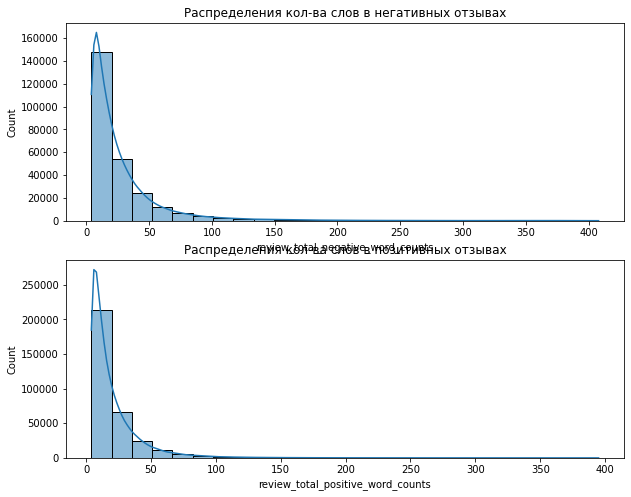

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=df_train[df_train['review_total_negative_word_counts'] > 3],
    x='review_total_negative_word_counts',
    bins=25,
    kde=True,
    ax=axes[0]
    )
sns.histplot(
    data=df_train[df_train['review_total_positive_word_counts'] > 3],
    x='review_total_positive_word_counts',
    bins=25,
    kde=True,
    ax=axes[1]
    )
axes[0].set_title('Распределения кол-ва слов в негативных отзывах')
axes[1].set_title('Распределения кол-ва слов в позитивных отзывах')

Text(0.5, 1.0, 'Распределения людей по суммарному количеству отзывов')

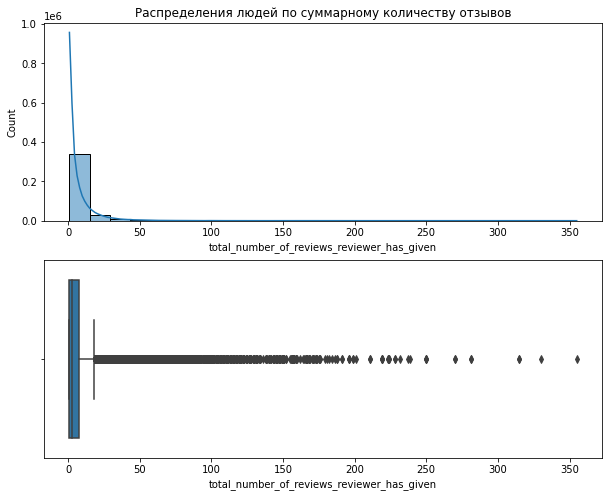

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=df_train,
    x='total_number_of_reviews_reviewer_has_given',
    bins=25,
    kde=True,
    ax=axes[0]
    )
sns.boxplot(
    data=df_train,
    x='total_number_of_reviews_reviewer_has_given',
    ax=axes[1]
    )
axes[0].set_title('Распределения людей по суммарному количеству отзывов')

Явно проявляются выбросы, не может человек успеть посетить пару сотен отелей и уж тем более возжелать каждому из них оставить отзыв. Попахивает накруткой. Удалять не будем. Создадим в будущем отдельный признак индикатор для этих записей.

(386314, 17)

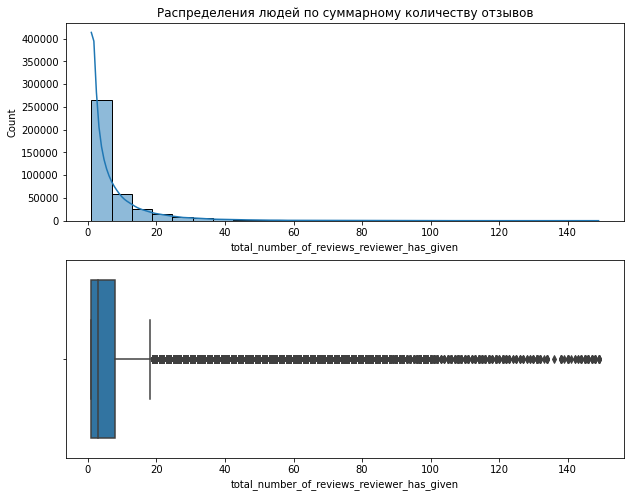

In [17]:
# Подберём значение для количества отзывов.
hist_data = df_train[df_train['total_number_of_reviews_reviewer_has_given'] < 70]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=hist_data,
    x='total_number_of_reviews_reviewer_has_given',
    bins=25,
    kde=True,
    ax=axes[0]
    )
sns.boxplot(
    data=hist_data,
    x='total_number_of_reviews_reviewer_has_given',
    ax=axes[1]
    )
axes[0].set_title('Распределения людей по суммарному количеству отзывов')
hist_data.shape

In [18]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [19]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515384 entries, 0 to 515383
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515384 non-null  object 
 1   additional_number_of_scoring                515384 non-null  int64  
 2   review_date                                 515384 non-null  object 
 3   average_score                               515384 non-null  float64
 4   hotel_name                                  515384 non-null  object 
 5   reviewer_nationality                        515384 non-null  object 
 6   negative_review                             515384 non-null  object 
 7   review_total_negative_word_counts           515384 non-null  int64  
 8   total_number_of_reviews                     515384 non-null  int64  
 9   positive_review                             515384 non-null  object 
 

Проверим, совпадают ли значения суммарного упоминания значений числа отзывов для отелей с количеством упоминаний названий.

In [20]:
display(hotels['hotel_name'].value_counts(),
       hotels['additional_number_of_scoring'].value_counts(),
       hotels['total_number_of_reviews'].value_counts())

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3577
DoubleTree by Hilton Hotel London Tower of London    3210
                                                     ... 
Hotel Daniel Paris                                     12
Boundary Rooms Suites                                  12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

2682    4789
2288    4256
2623    4169
1831    3577
1936    3210
        ... 
7         56
5         39
17        24
1         13
4         12
Name: additional_number_of_scoring, Length: 480, dtype: int64

9086     4789
9568     4256
12158    4169
7105     3577
7491     3210
         ... 
45         12
131        12
66         12
43         12
110        10
Name: total_number_of_reviews, Length: 1142, dtype: int64

Количество упоминанний отзывов без комментария "additional_number_of_scoring" совпадает с количеством упоминаний имён отелей и количеством отзывов об отеле, это является характеристикой для отелей, а не для отзыва. Количество отзывов и отзывов без комментария, явно будут коррелировать (P.S. что и показал эксперимент в будущем).
Создадим признак "review_proportinon" - соотношение оценок без комментария к общему количеству оценок, а скоррелированные признаки удалим.

In [21]:
hotels['review_proportion'] = hotels['additional_number_of_scoring'] / \
    hotels['total_number_of_reviews']
drop_cols = ['additional_number_of_scoring', 'total_number_of_reviews']
hotels.drop(drop_cols, axis=1, inplace=True)

In [22]:
# Создадим признак-маркер "bot" для записей оставленных пользователями 
# с большим количеством отзывов 
hotels['bot'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: 1 if x > 70 else 0)

In [23]:
# Посмотрим на формат адреса
display(hotels['hotel_address'][:20])


0                                                    Via Senigallia 6 20161 Milan Italy
1                                 Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
2                                           Mallorca 251 Eixample 08008 Barcelona Spain
3                          Piazza Della Repubblica 17 Central Station 20124 Milan Italy
4                    Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
5                                    Coram Street Camden London WC1N 1HT United Kingdom
6                                Empire Way Wembley Brent London HA9 8DS United Kingdom
7                      1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom
8                                           35 Rue Caumartin 9th arr 75009 Paris France
9     49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom
10                                          Via Giorgio Stephenson 55 20157 Milan Italy
11                        Spaarn

In [24]:
# Определим представленные в выборке страны
country_list = hotels['hotel_address'].apply(lambda x:
    'United Kingdom' if x.split()[-1] == 'Kingdom'
    else x.split()[-1]).unique()
display(country_list)

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

In [25]:
# Посмотрим на представленные в выборке города
display(hotels['hotel_address'].apply(lambda x:
    x.split()[-5] if x.split()[-1] == 'Kingdom'
    else x.split()[-2]).unique())

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [26]:
# Количество городов совпадает с количеством стран. В качестве признака выделим
# страну отеля, так как в будущем планирую создать признак является ли клиент
# гражданином страны отеля.
hotels['country'] = hotels['hotel_address'].apply(lambda x:
    'United Kingdom' if x.split()[-1] == 'Kingdom'
    else x.split()[-1]).astype('category')
# Признак с адрессом удалим. 
hotels.drop('hotel_address', axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515384 entries, 0 to 515383
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   review_date                                 515384 non-null  object  
 1   average_score                               515384 non-null  float64 
 2   hotel_name                                  515384 non-null  object  
 3   reviewer_nationality                        515384 non-null  object  
 4   negative_review                             515384 non-null  object  
 5   review_total_negative_word_counts           515384 non-null  int64   
 6   positive_review                             515384 non-null  object  
 7   review_total_positive_word_counts           515384 non-null  int64   
 8   total_number_of_reviews_reviewer_has_given  515384 non-null  int64   
 9   tags                                        515384 non-null

In [27]:
# Определим средние координаты по странам (городам) отелей
lat_dict = {}
lng_dict = {}
for country in country_list:
    mask = hotels['country'] == country
    lat = hotels[mask]['lat'].mean()
    lat_dict.update({country: lat})
    lng = hotels[mask]['lng'].mean()
    lng_dict.update({country: lng})

display(lat_dict, lng_dict)
    

{'Italy': 45.4796075340278,
 'Netherlands': 52.362206523391315,
 'Spain': 41.38907926629127,
 'United Kingdom': 51.51073944948738,
 'France': 48.86382425137411,
 'Austria': 48.20336178125103}

{'Italy': 9.191832353383155,
 'Netherlands': 4.885405583265449,
 'Spain': 2.169146231583162,
 'United Kingdom': -0.13896020694946984,
 'France': 2.326800545369526,
 'Austria': 16.367233384979865}

In [28]:
# Заполняем пропуски координат
hotels['lat'] = hotels[['country', 'lat']].apply(lambda x:
    lat_dict[x.country] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['country', 'lng']].apply(lambda x:
    lng_dict[x.country] if np.isnan(x.lng) else x.lng, axis=1)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515384 entries, 0 to 515383
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   review_date                                 515384 non-null  object  
 1   average_score                               515384 non-null  float64 
 2   hotel_name                                  515384 non-null  object  
 3   reviewer_nationality                        515384 non-null  object  
 4   negative_review                             515384 non-null  object  
 5   review_total_negative_word_counts           515384 non-null  int64   
 6   positive_review                             515384 non-null  object  
 7   review_total_positive_word_counts           515384 non-null  int64   
 8   total_number_of_reviews_reviewer_has_given  515384 non-null  int64   
 9   tags                                        515384 non-null

Эксперимент показал, что значение месяца отзыва не особо влияют. Закоментим

In [29]:
# Меняем тип данных для признака "даты отзыва"
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Создаем признак "месяц отзыва"
#hotels['review_month'] = pd.to_datetime(
#    hotels['review_date']).dt.month.astype('category')
# Создаем признак "День недели отзыва"
hotels['review_day'] = pd.to_datetime(
    hotels['review_date']).dt.day_of_week.astype('category')

# Меняем тип признака "кол-во дней после отзыва" на числовой
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x:
                            int(x.replace(' days', '').replace(' day', '')))

hotels.drop('review_date', axis=1, inplace=True)


Есть предположение, что отзыв зависит от таких факторов: 
1. является ли постоялец гражданином страны члена ЕС или мусульманской.
2. как хорошо постоялец владеет английским языком.
3. является ли постоялец гражданином страны, в которой расположен отель.

In [30]:
# Категоризируем клиентов по национальности. Чтобы не плодить признаки выделим
# максимальное количество которое можно закодировать 6-ю битами (столбцами)
country_list = list(hotels['reviewer_nationality'].value_counts()[:62].index)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: 
                                            x if x in country_list else 'other')
display(hotels['reviewer_nationality'].value_counts())

 United Kingdom               245159
 United States of America      35389
 Australia                     21663
 Ireland                       14819
other                          14467
 United Arab Emirates          10228
 Saudi Arabia                   8941
 Netherlands                    8762
 Switzerland                    8668
 Germany                        7936
 Canada                         7886
 France                         7277
 Israel                         6604
 Italy                          6112
 Belgium                        6027
 Turkey                         5441
 Kuwait                         4916
 Spain                          4729
 Romania                        4548
 Russia                         3896
 South Africa                   3818
 India                          3434
 Greece                         3401
 China                          3398
 Sweden                         3364
 New Zealand                    3235
 Singapore                      3089
 

In [31]:
# создадим списки стран где английский язык не является государственным 
# в зависимости от уровня владения по стране.
# (таблицы создал на основе EF English Proficiency Index)
import re

file = open('data' + '/very_low_proficiency.txt', "r") #Открываем файл
very_low_proficiency = []
line = file.readline()
while line:
    # r'[^\w\s]+|[\d]+' - регулярное выражения для очистки строки от "мусора" 
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    very_low_proficiency.append(country) # вставляем в список название страны
    line = file.readline()

file = open('data' + '/low_proficiency.txt', "r") 
low_proficiency = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    low_proficiency.append(country)
    line = file.readline()

file = open('data' + '/moderate.txt', "r")
moderate = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    moderate.append(country)
    line = file.readline()
    
file = open('data' + '/high.txt', "r")
high = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    high.append(country)
    line = file.readline()
    
file = open('data' + '/very_high.txt', "r")
very_high = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    very_high.append(country)
    line = file.readline()

# Удалим пробелы внчале и в конце строки страны постояльца.
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x.strip()).astype('category')
    
hotels['eng_proficiency'] = hotels['reviewer_nationality'].apply(lambda x:
    1 if x in very_low_proficiency 
    else 2 if x in low_proficiency
    else 3 if x in moderate or x == 'other'
    else 4 if x in high
    else 5 if x in very_high
    else 6 # группа где английский - государственный язык
    ).astype('category')

hotels[hotels['eng_proficiency'] == 6]['reviewer_nationality'].unique()

['United Kingdom', 'United States of America', 'Ireland', 'Canada', 'Australia', ..., 'Jersey', 'Hong Kong', 'Malta', 'Taiwan', 'New Zealand']
Length: 11
Categories (63, object): ['Australia', 'Austria', 'Bahrain', 'Belgium', ..., 'United Arab Emirates', 'United Kingdom', 'United States of America', 'other']

Text(0.5, 1.0, 'Средняя оценка в зависимости от владения английским')

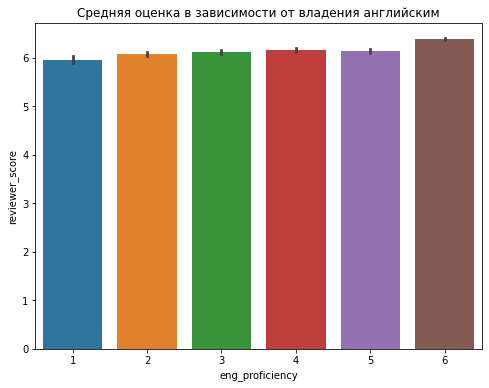

In [32]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=hotels, x='eng_proficiency', y='reviewer_score')
ax.set_title('Средняя оценка в зависимости от владения английским')

Так как в разных социальных группах требования к окружающиму миру разные, возможно на оценку влияет принадлежность к той или иной культурной группе. 
Все отели европейские. Попробуем выделить принадлежность национальности отдыхающего к мусульманскому миру.
Так же создадим признак из Евросоюза отдыхающий или нет.

P.S. Как показал эксперимент, данная сегрегация результата не дала, но зато в парсинге потренировался).

In [33]:
# Спарсим список стран и процент исповедующих ислам 
url = requests.get('https://www.worlddata.info/religions/islam.php').text
soup = BeautifulSoup(url,'lxml')
table = soup.find('table', {'class': 'std100'})
country_list = [] # список стран из таблицы
muslims_list = [] # процент исповедывающих ислам
i = 0
for tag in table.find_all('td'):
    if i == 0:
        country_list.append(tag.text)
    if i == 1:
        muslims_list.append(tag.text)
    i += 1
    if i == 3:
        i = 0
        
# Создадим датафрейм из списка стран и соответствующего процента мусульман    
muslims_data = pd.DataFrame(
    list(zip(country_list, muslims_list)),
    columns=['country', 'percent'])
muslims_data['percent'] = muslims_data['percent'].apply(lambda x:
    float(x.replace(' %', '')))
# Выделим топ 40 стран по проценту мусульман и занесем названия в список
muslims_top = muslims_data.sort_values(by='percent', ascending=False)[:40]
muslims_country = muslims_top['country'].tolist()
print(muslims_country)

# Создадим список стран-членов ЕС
eu_str = "Austria, Belgium, Bulgaria, Croatia, Republic of Cyprus, \
Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, \
Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, \
Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden"
eu_list = eu_str.split(', ')

['Maldives', 'Mauritania', 'Somalia', 'Tunisia', 'Saudi Arabia', 'Morocco', 'Afghanistan', 'Algeria', 'Turkey', 'Comoros', 'Yemen', 'Iraq', 'Libya', 'Iran', 'Kosovo', 'Pakistan', 'Mali', 'Jordan', 'Senegal', 'Djibouti', 'Azerbaijan', 'Palestine', 'Gambia', 'Egypt', 'Tajikistan', 'Bangladesh', 'Syria', 'Turkmenistan', 'Uzbekistan', 'Indonesia', 'Oman', 'Guinea', 'Niger', 'Brunei', 'Qatar', 'United Arab Emirates', 'Kyrgyzstan', 'Kuwait', 'Bahrain', 'Kazakhstan']


In [34]:
# Создадим признак указывающий относится ли родина отдыхающего
# к мусульманской стране
hotels['is_muslim'] = hotels['reviewer_nationality'].apply(lambda x: 
    1 if x in muslims_country else 0)

# Создадим признак указывающий относится ли родина отдыхающего к ЕС
hotels['from_eu'] = hotels['reviewer_nationality'].apply(lambda x: 
    1 if x in eu_list else 0)

In [35]:
# Создадим признак указывающий, "местный" ли постоялец
hotels['is_local'] = hotels[['country', 'reviewer_nationality']].apply(
    lambda x: 1 if x['country'] == x['reviewer_nationality'] else 0, axis=1)

hotels.drop('country', axis=1, inplace=True)
#hotels['is_local'].value_counts()

#plt.figure(figsize=(8,6))
#ax = sns.barplot(data=hotels, x='is_local', y='reviewer_score')
#ax.set_title('Средняя оценка в зависимости от местный или нет')

In [36]:
# Выявим самые популярные тэги признака "tags"
from collections import Counter

tags_list = hotels['tags'].tolist()
tags = []
for i in tags_list:
    symbols = ["[", "]", "'"]
    for j in symbols:
        i = i.replace(j, '')
    tags += i.split(',')
# Выведем топ30 тэгов
pop_tag = Counter(tags).most_common(30)
display(pop_tag)

[(' Leisure trip ', 416396),
 ('  Submitted from a mobile device ', 307461),
 ('  Couple ', 246313),
 ('  Stayed 1 night ', 193547),
 ('  Stayed 2 nights ', 133839),
 ('  Solo traveler ', 104172),
 ('  Stayed 3 nights ', 95752),
 (' Business trip ', 82686),
 ('  Group ', 63753),
 ('  Family with young children ', 58760),
 ('  Stayed 4 nights ', 47773),
 ('  Double Room ', 35197),
 ('  Standard Double Room ', 32245),
 ('  Superior Double Room ', 31360),
 ('  Family with older children ', 25400),
 ('  Deluxe Double Room ', 24809),
 ('  Double or Twin Room ', 22392),
 ('  Stayed 5 nights ', 20826),
 ('  Standard Double or Twin Room ', 17479),
 ('  Classic Double Room ', 16876),
 ('  Superior Double or Twin Room ', 13567),
 ('  2 rooms ', 12383),
 ('  Stayed 6 nights ', 9765),
 ('  Standard Twin Room ', 9744),
 ('  Single Room ', 9667),
 ('  Twin Room ', 8319),
 ('  Stayed 7 nights ', 7390),
 ('  Executive Double Room ', 6425),
 ('  Classic Double or Twin Room ', 6099),
 ('  Superior Twin 

Из списка популярных тегов можно вывести бинарные и категориальные признаки:
* Тип путешествия "leisure_trip"(Leisure/Business Trip) 416432 + 82693 = 499125
* Источник отзыва "mobile_submit" (с мобильного девайса или нет)
* Количество ночей "nights_count"(Stayed n nights)
* Один, пара или группа путешественников "people_count"
* Постоялец с маленьким ребёнком "children"

Создадим эти признаки.


In [37]:
hotels['leisure_trip'] = hotels['tags'].apply(lambda x:
    1 if 'Leisure trip' in x else 0) 
hotels['mobile_submit'] = hotels['tags'].apply(lambda x:
    1 if 'Submitted from a mobile device' in x else 0) 
hotels['nights_count'] = hotels['tags'].apply(lambda x: 
    1 if 'Stayed 1 night' in x else
    2 if 'Stayed 2 nights' in x else
    3 if 'Stayed 3 nights' in x else
    4) 
hotels['people_count'] = hotels['tags'].apply(lambda x: 
    1 if 'Solo traveler' in x else
    2 if 'Couple' in x else
    0)
hotels['children'] = hotels['tags'].apply(lambda x: 
    1 if 'Family with young children' in x else 0)
hotels['people_count'].value_counts()

hotels.drop('tags', axis=1, inplace=True)


In [38]:
#кодируем признаки
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
rev_nations_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, rev_nations_bin], axis=1)

hotels.drop('reviewer_nationality', axis=1, inplace=True)

oh_cols = ['nights_count', 'people_count', 'review_day']# указываем столбцы для кодирования
encoder = ce.OneHotEncoder(cols=oh_cols) 
country_oh = encoder.fit_transform(
    hotels[['nights_count', 'people_count', 'review_day']])
hotels = pd.concat([hotels, country_oh], axis=1)

hotels.drop(oh_cols, axis=1, inplace=True)

In [39]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515384 entries, 0 to 515383
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515384 non-null  float64 
 1   hotel_name                                  515384 non-null  object  
 2   negative_review                             515384 non-null  object  
 3   review_total_negative_word_counts           515384 non-null  int64   
 4   positive_review                             515384 non-null  object  
 5   review_total_positive_word_counts           515384 non-null  int64   
 6   total_number_of_reviews_reviewer_has_given  515384 non-null  int64   
 7   days_since_review                           515384 non-null  int64   
 8   lat                                         515384 non-null  float64 
 9   lng                                         515384 non-null

In [40]:
# Проведем анализ эмоционального окраса отзывов и создадим признаки
# с результатами для негативных и позитивных отзывов
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

hotels['positive_sent_score'] = hotels['positive_review'].apply(
    sent_analyzer.polarity_scores)
hotels['negative_sent_score'] = hotels['negative_review'].apply(
    sent_analyzer.polarity_scores)

# Анализ корреляции показал, что "нейтральная" оценка сильно кореллирует
# с другими оценками эмоционалности сообщения, поэтому не будем создавать
# для неё признак.
hotels['positive_neg'] = hotels['positive_sent_score'].apply(lambda x: 
    x['neg'])
#hotels['positive_neu'] = hotels['positive_sent_score'].apply(lambda x: 
#    x['neu'])
hotels['positive_pos'] = hotels['positive_sent_score'].apply(lambda x: 
    x['pos'])
hotels['positive_compound'] = hotels['positive_sent_score'].apply(lambda x:
    x['compound'])
hotels['negative_neg'] = hotels['negative_sent_score'].apply(lambda x: 
    x['neg'])
#hotels['negative_neu'] = hotels['negative_sent_scorew'].apply(lambda x:
#    x['neu'])
hotels['negative_pos'] = hotels['negative_sent_score'].apply(lambda x: 
    x['pos'])
hotels['negative_compound'] = hotels['negative_sent_score'].apply(lambda x: 
    x['compound'])

hotels.drop('positive_sent_score', axis=1, inplace=True)
hotels.drop('negative_sent_score', axis=1, inplace=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
pearson_cols = []
spearmen_cols = []

Text(0.5, 1.0, 'Корреляция Пирсона')

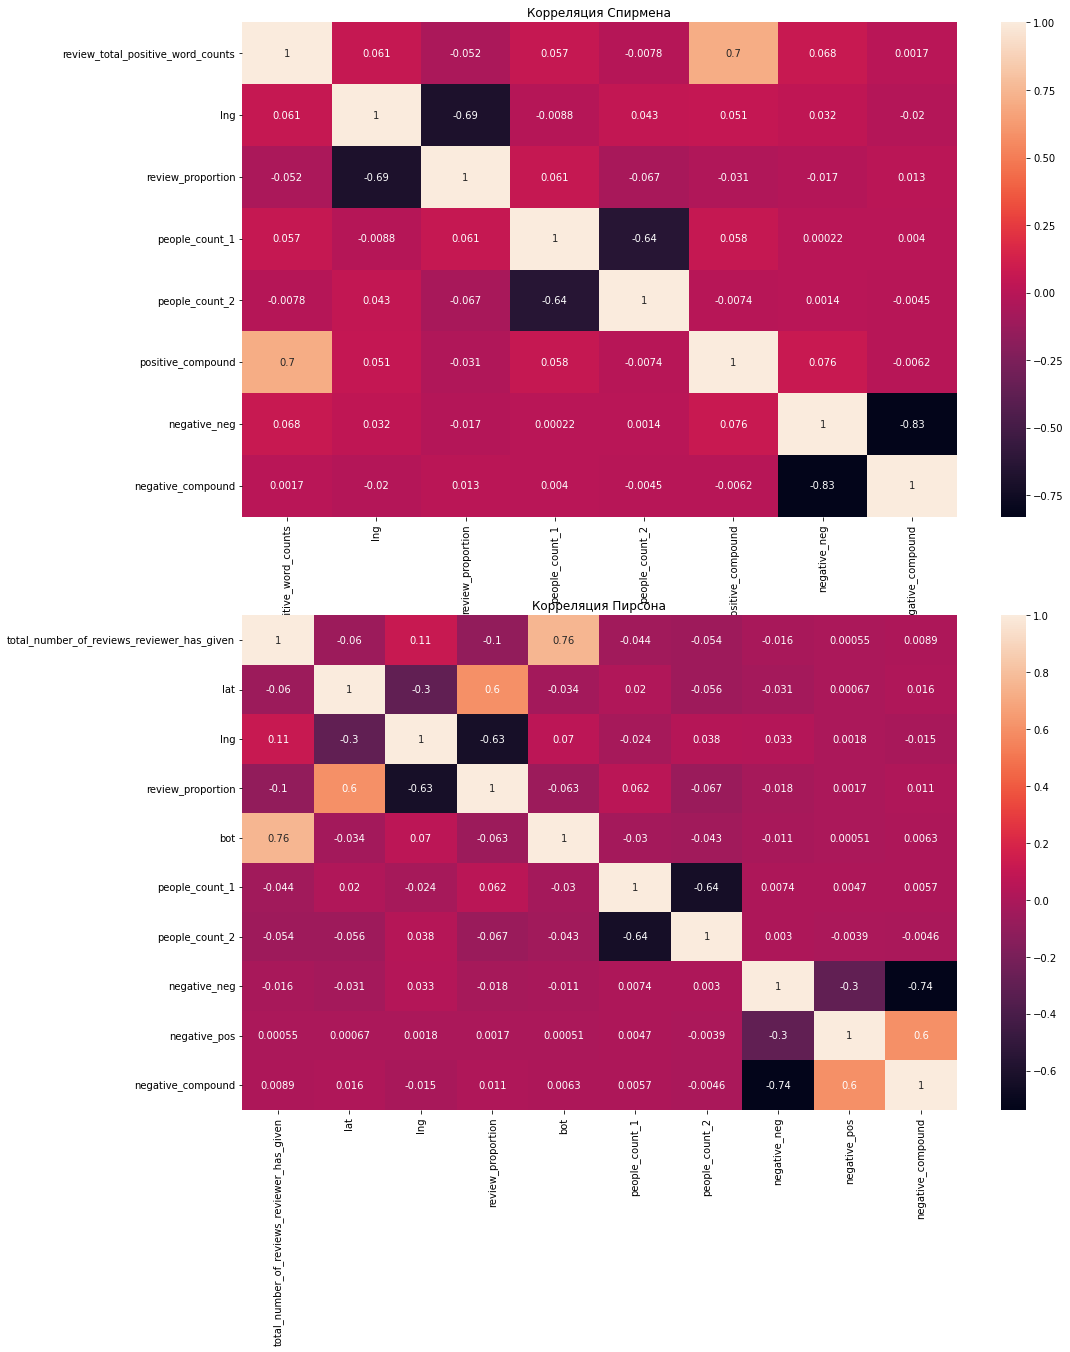

In [42]:
# Выведем корреляцию по методу Писрона и Спирмена для признаков имеющим 
# хотя бы одну корреляцию выше 0.6
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (16,20))

spearman_data = hotels.drop(['sample'], axis=1).corr(method='spearman')
col_list = []

for feature in spearman_data.columns:
    if abs(spearman_data[spearman_data[feature] != 1][feature]).max() > 0.6:
        col_list.append(feature)
    
sns.heatmap(spearman_data[col_list].loc[col_list], annot=True, ax=axes[0])

pearson_data = hotels.drop(['sample'], axis=1).corr(method='pearson')
col_list = []

for feature in pearson_data.columns:
    if abs(pearson_data[pearson_data[feature] != 1][feature]).max() > 0.6:
        col_list.append(feature)
    
sns.heatmap(pearson_data[col_list].loc[col_list], annot=True, ax=axes[1])

axes[0].set_title('Корреляция Спирмена')
axes[1].set_title('Корреляция Пирсона')

In [127]:
# Определяем коррелирующие признаки в зависимости от типа признака и типа корреляции.
# Удаляем текстовые признаки, признаки с высокой корреляцией и 
# малозначительные признаки 
object_cols = [s for s in hotels.columns if hotels[s].dtypes == 'object']
corr_cols = ['negative_neg']
trash_cols = ['lat','lng', 'is_local', 'reviewer_nationality_0',
              'reviewer_nationality_1', 'reviewer_nationality_2',
              'nights_count_4', 'bot', 'is_muslim', 'from_eu', 'children']
drop_cols = object_cols + corr_cols + trash_cols
hotels_ml = hotels.drop(drop_cols, axis = 1)
hotels_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515384 entries, 0 to 515383
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515384 non-null  float64 
 1   review_total_negative_word_counts           515384 non-null  int64   
 2   review_total_positive_word_counts           515384 non-null  int64   
 3   total_number_of_reviews_reviewer_has_given  515384 non-null  int64   
 4   days_since_review                           515384 non-null  int64   
 5   sample                                      515384 non-null  int64   
 6   reviewer_score                              515384 non-null  float64 
 7   review_proportion                           515384 non-null  float64 
 8   eng_proficiency                             515384 non-null  category
 9   leisure_trip                                515384 non-null

Нормализация ухудшила результаты. Не будем нормализовывать.

In [128]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
# выделяем все признаки кроме целевого
hotels_ml_mm = hotels_ml.drop(['reviewer_score'], axis=1)
col_names = list(hotels_ml_mm.columns)
hotels_ml_mm = mm_scaler.fit_transform(hotels_ml_mm)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_ml_mm = pd.DataFrame(hotels_ml_mm, columns=col_names)
hotels_ml_mm['reviewer_score'] = hotels_ml['reviewer_score']
hotels_ml_mm.describe()


,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,review_proportion,eng_proficiency,leisure_trip,mobile_submit,...,review_day_4,review_day_5,review_day_6,review_day_7,positive_neg,positive_pos,positive_compound,negative_pos,negative_compound,reviewer_score
count,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,...,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000,515384.000
mean,0.695,0.045,0.045,0.017,0.485,0.750,0.421,0.816,0.810,0.597,...,0.100,0.235,0.114,0.163,0.035,0.389,0.795,0.053,0.396,6.297
std,0.119,0.073,0.055,0.031,0.286,0.433,0.201,0.293,0.392,0.491,...,0.301,0.424,0.317,0.369,0.103,0.236,0.173,0.116,0.227,3.903
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.630,0.005,0.013,0.000,0.240,0.000,0.235,0.600,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.230,0.673,0.000,0.145,0.000
50%,0.696,0.022,0.028,0.006,0.484,1.000,0.414,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.404,0.854,0.000,0.411,7.900
75%,0.783,0.056,0.056,0.020,0.722,1.000,0.581,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.588,0.942,0.057,0.500,9.600
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10.000


In [129]:
# Теперь выделим тестовую часть
train_data = hotels_ml.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_ml.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [130]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [131]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386449, 32), (386449, 31), (309159, 31), (77290, 31))

In [132]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [133]:
# Добавляем логгирование нашего эксперимента

# Функция для создания лог-файла и записи в него информации
def get_logger(path, file):
  """[Создает лог-файл для логирования в него]
  Аргументы:
      path {string} -- путь к директории
      file {string} -- имя файла
   Возвращает:
      [obj] -- [логер]
  """
  # проверяем, существует ли файл
  log_file = os.path.join(path, file)
 
  #если  файла нет, создаем его
  if not os.path.isfile(log_file):
    open(log_file, "w+").close()
  
  # зададим формат логирования
  file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"
  
  logger = logging.getLogger()

  # создадим хэнлдер для записи лога в файл
  handler = logging.FileHandler(log_file)
  
  # установим уровень логирования
  handler.setLevel(logging.INFO)
  
  # создадим формат логирования, используя file_logging_format
  formatter = logging.Formatter(file_logging_format)
  handler.setFormatter(formatter)
  
  # добавим хэндлер лог-файлу
  logger.addHandler(handler)
  return logger

logger = get_logger(path="logs", file="data.logs")

logger.setLevel(10) 

logger.info(f"Оставил все признаки. Будем пробовать подбор на Kaggle. \n \
Коррелирующие признаки {corr_cols} \n Незначительные признаки {trash_cols}\n")

In [134]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [135]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [136]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
print('MAPE:', mape)
logger.info(f'MAPE: {mape}')
print('MAE:', mae)
logger.info(f'MAE: {mae}')

MAPE: 0.1248549565256496
MAE: 0.8747895389657995


<AxesSubplot:>

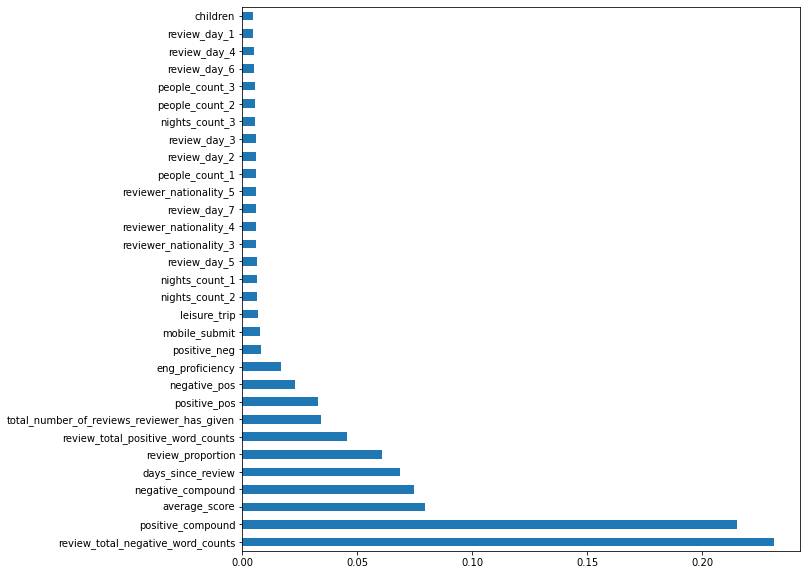

In [137]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(68).plot(kind='barh')

In [138]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,review_proportion,eng_proficiency,leisure_trip,mobile_submit,...,review_day_3,review_day_4,review_day_5,review_day_6,review_day_7,positive_neg,positive_pos,positive_compound,negative_pos,negative_compound
126735,7.400,26,9,1,83,0.000,0.164,6,1,1,...,0,0,0,0,0,0.000,0.500,0.718,0.000,-0.296
9403,8.600,0,16,3,179,0.000,0.301,6,1,1,...,0,0,0,0,1,0.086,0.670,0.924,0.000,-0.710
15825,8.200,3,6,1,24,0.000,0.141,6,1,1,...,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000
11536,9.000,18,27,1,217,0.000,0.272,6,1,0,...,1,0,0,0,0,0.088,0.000,-0.341,0.144,0.178
66001,8.600,8,10,7,207,0.000,0.108,5,0,0,...,0,0,0,0,1,0.000,0.699,0.912,0.000,-0.440
228,8.500,2,4,1,487,0.000,0.073,6,1,0,...,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000
70693,8.700,56,23,9,265,0.000,0.091,6,0,0,...,0,0,0,0,0,0.000,0.505,0.946,0.000,-0.664
124963,9.100,8,4,42,241,0.000,0.270,6,0,0,...,0,0,0,0,0,0.000,0.861,0.735,0.000,0.000
60157,9.000,0,86,7,202,0.000,0.236,6,1,1,...,0,0,0,0,0,0.015,0.241,0.973,0.000,-0.710
42525,7.300,16,0,1,157,0.000,0.219,6,1,0,...,0,0,0,0,0,0.379,0.621,0.340,0.000,-0.296


In [139]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [140]:
sample_submission

,reviewer_score,id
0,8.433,488440
1,7.212,274649
2,7.962,374688
3,9.642,404352
4,9.604,451596
...,...,...
128930,8.817,495812
128931,9.467,315577
128932,8.112,511968
128933,9.506,303386


In [141]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [142]:
predict_submission

array([8.517, 7.325, 8.011, ..., 7.983, 9.51 , 6.922])

In [143]:
list(sample_submission)

['reviewer_score', 'id']

In [144]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.517,488440
1,7.325,274649
2,8.011,374688
3,9.654,404352
4,9.534,451596
5,8.757,302161
6,8.031,317079
7,7.751,13963
8,8.646,159785
9,7.575,195089
